In [1]:
# ladt modified in 26-05-2019 in 18:00

## Import libs

In [2]:
import networkx as nx # the main libary we will use
from networkx.algorithms import bipartite
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit 
from itertools import combinations
# %pip install nxviz
from nxviz.plots import CircosPlot
from nxviz import ArcPlot
import seaborn as sns
import matplotlib.pyplot as plt
from functools import reduce
import dask
import dask.array as da, dask.dataframe as dd
from tqdm import tqdm

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

# Data Prep:
1. add features
2. connect the movie name
3. change data type of the columns
4. filter some movies

In [3]:
N_MOVIES = 100
MIN_RATING = 50
SEED = 4

# set seed
np.random.seed(SEED)
df = pd.read_csv(r"25k_users_sample.csv")
df_movies = pd.read_csv(r"movie_titles.csv", names=["year","title"], index_col=0, encoding="ISO-8859-1",parse_dates=True)

df["movie"] = df["movie"].astype(str)
df["date"] = pd.to_datetime(df["date"])
df_movies.fillna(0,inplace=True)
df_movies["year"] = df_movies["year"].astype("int64")
df_movies["movie"] = df_movies.index
df = df.merge(df_movies, on="movie", how="left")
df['week_day'] = df['date'].dt.day_name()
df['year_rating'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day_month'] = df['date'].dt.daysinmonth
df['edge'] = list(zip(df.user, df.movie,df.rating))
display(df.head(2))

# filter some movies with number of rating lower than min_number_of rating
movie_rating_counts = df['movie'].value_counts().to_frame()
movies_with_more_than_50_ratings = movie_rating_counts[movie_rating_counts > MIN_RATING].index.tolist()
df = df[df.movie.isin(movies_with_more_than_50_ratings)]

movie_rating_counts = df['movie'].value_counts().to_frame()
movie_rating_counts['movie'] = movie_rating_counts['movie']/movie_rating_counts['movie'].sum()
sample_movies = np.random.choice(movie_rating_counts.index, N_MOVIES, p= movie_rating_counts['movie'].values,replace=False)
df = df[df.movie.isin(sample_movies)]
display(df.shape)

,user,rating,date,movie,year,title,week_day,year_rating,month,day_month,edge
0,2625420,2.0,2004-05-25,13368,1999,Sarfarosh,Tuesday,2004,5,31,"(2625420, 13368, 2.0)"
1,1650301,1.0,2005-08-30,13368,1999,Sarfarosh,Tuesday,2005,8,31,"(1650301, 13368, 1.0)"


(518265, 11)

## Visualization

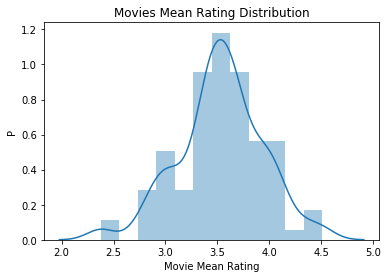

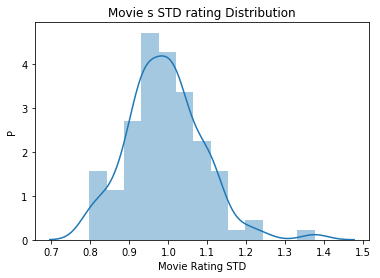

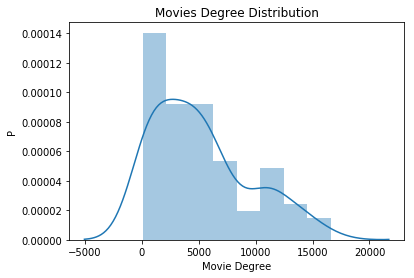

most_rated_movies:


,title,count
40,Ocean's Eleven,16595
63,Con Air,14900
82,Indiana Jones and the Last Crusade,14656
67,The Fugitive,14295
26,Shrek (Full-screen),14124
23,How to Lose a Guy in 10 Days,13261
22,Lethal Weapon 4,12931
8,Air Force One,12686
24,You've Got Mail,12087
44,Traffic,11560


best_movies:


,title,mean
64,Star Wars: Episode IV: A New Hope,4.511379
73,The Simpsons: Season 4,4.489112
82,Indiana Jones and the Last Crusade,4.336381
26,Shrek (Full-screen),4.305084
38,Sex and the City: Season 2,4.139659
16,The Notebook,4.124038
65,ER: Season 2,4.116211
18,Mary Poppins,4.098508
68,Prime Suspect 4,4.053299
67,The Fugitive,4.037216


most_consistent_movies:


,title,std
82,Indiana Jones and the Last Crusade,0.796942
64,Star Wars: Episode IV: A New Hope,0.799009
67,The Fugitive,0.800701
73,The Simpsons: Season 4,0.813719
37,The Dirty Dozen,0.825538
26,Shrek (Full-screen),0.834215
6,The Client,0.840372
60,Dave,0.862065
94,F/X,0.868362
45,A Perfect Murder,0.869698


In [4]:
### Movies
grouped_movies = df.groupby(['movie','title'])['rating'].agg(['mean','count','std']).reset_index() 

ax = sns.distplot(grouped_movies['mean'])
ax.set(xlabel='Movie Mean Rating', ylabel='P',title = 'Movies Mean Rating Distribution')
plt.show()

ax = sns.distplot(grouped_movies['std'])
ax.set(xlabel='Movie Rating STD', ylabel='P',title = 'Movie s STD rating Distribution')
plt.show()

ax = sns.distplot((grouped_movies['count']))
ax.set(xlabel='Movie Degree', ylabel='P',title = 'Movies Degree Distribution')
plt.show()

print('most_rated_movies:')
display(grouped_movies.nlargest(10, 'count')[['title','count']])
print('best_movies:')
display(grouped_movies.nlargest(10, 'mean')[['title','mean']])
print('most_consistent_movies:')
display(grouped_movies.nsmallest(10, 'std')[['title','std']])

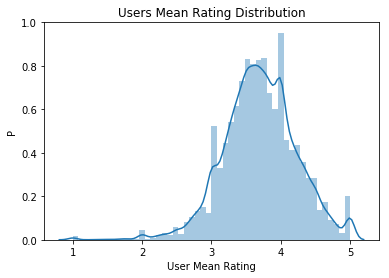

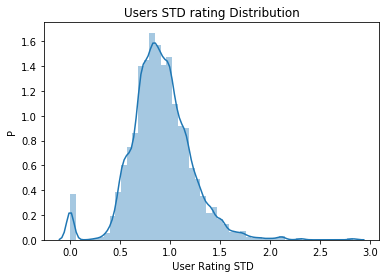

[Text(0, 0.5, 'P'),
 Text(0.5, 0, 'User Movie Degree'),
 Text(0.5, 1.0, 'Users Movie Degree Distribution')]

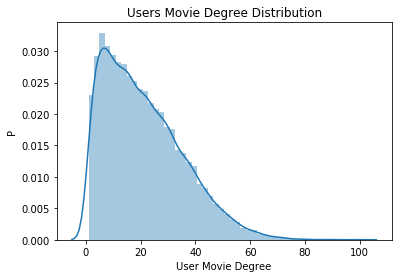

In [5]:
### Users
grouped_users = df.groupby('user')['rating'].agg(['mean','count','std']) 
ax = sns.distplot(grouped_users['mean'])
ax.set(xlabel='User Mean Rating', ylabel='P',title = 'Users Mean Rating Distribution')
plt.show()

ax = sns.distplot(grouped_users['std'].dropna())
ax.set(xlabel=' User Rating STD', ylabel='P',title = 'Users STD rating Distribution')
plt.show()

ax = sns.distplot(grouped_users['count'])
ax.set(xlabel='User Movie Degree', ylabel='P',title = 'Users Movie Degree Distribution')

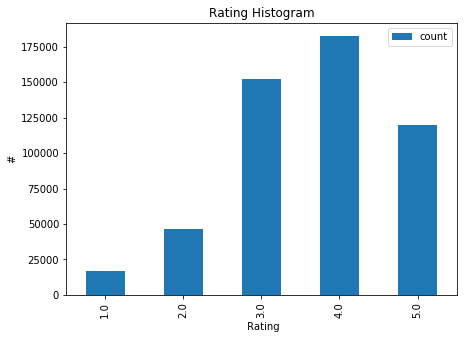

In [36]:
def rating_plot(df):
    ax = df.groupby(['rating']).size().reset_index(name='count').plot(x='rating',y=['count'], figsize=(7,5),kind='bar')
    ax.set(xlabel=' Rating', ylabel='#',title = 'Rating Histogram')
    plt.show()
rating_plot(df)

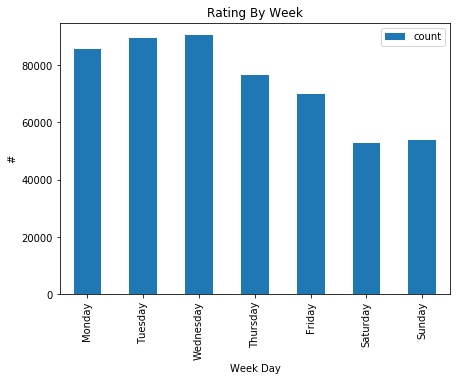

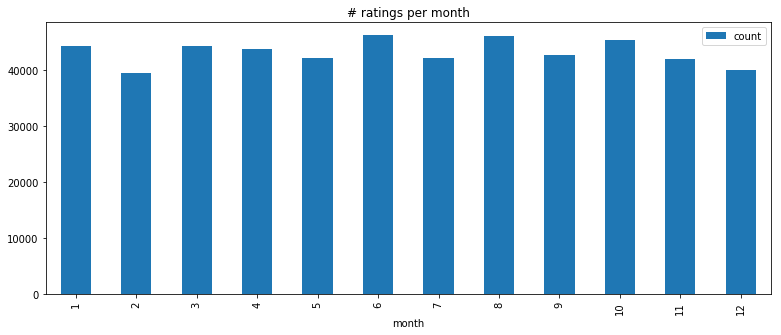

In [39]:
# Temporal Exploration
# days of week
weekdays = ['Monday', 'Tuesday', 'Wednesday','Thursday','Friday', 'Saturday', 'Sunday']
mapping = {day: i for i, day in enumerate(weekdays)}
df_group_week_day = df.groupby('week_day')['rating'].agg(['mean','count','std'])
key = df_group_week_day.index.map(mapping)
ax = df_group_week_day.iloc[key.argsort()].plot.bar(y = 'count', figsize = (7,5))
ax = ax.set(xlabel='Week Day', ylabel='#',title = 'Rating By Week')

df_group_month = df.groupby('month')['rating'].agg(['mean','count','std'])
df_group_month.plot.bar(y = 'count',figsize=(13, 5), title='# ratings per month')

plt.show()

# Movies and Users Degree Dist

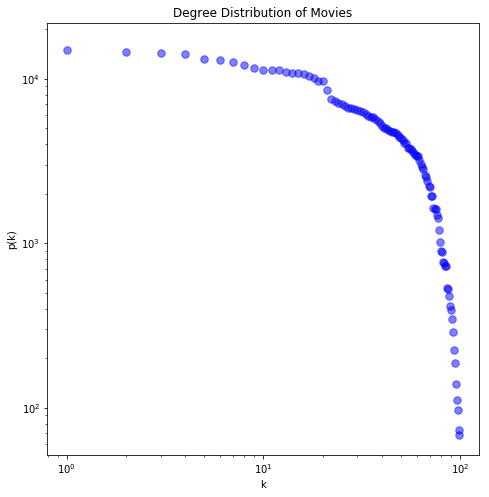

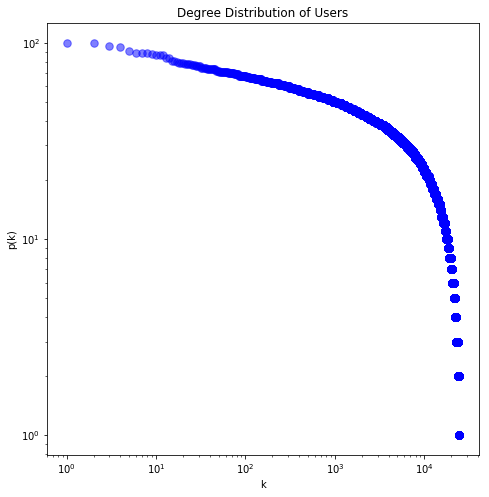

In [9]:
def plot_degree_dist(degree_hist,header,G = None):
    degree_hist = np.array(degree_hist, dtype=float)
    if G is not None:
        degree_prob = degree_hist/G.number_of_nodes()
    else:
        degree_prob = degree_hist
    # plotting
    fig = plt.figure(figsize=(6,6))
    axes = fig.add_axes([1,1,1,1])
    axes.loglog(np.arange(degree_prob.shape[0]), degree_prob, 'b.', markersize=15, alpha=0.5)
    axes.set_xlabel('k')
    axes.set_ylabel('p(k)')
    axes.set_title('Degree Distribution of {}'.format(header))
    plt.show()

plot_degree_dist(df['movie'].value_counts(),'Movies')
plot_degree_dist(df['user'].value_counts(),'Users')

# Degree distribution for the movies projection graph
1. Create the bipartite graph
2. create a projection of the movies graph
3. plot the degree distribution of the projected graph

# Create a bipartite graph, nodes and edges and the movies projected graph

matrix shape is : (100, 24675)
True
Number of nodes: 24775
Number of edges: 518265


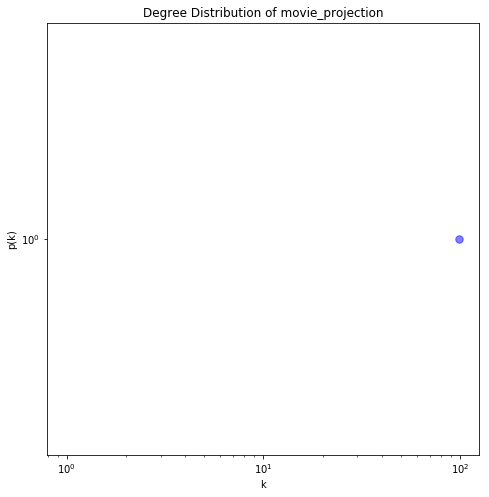

In [13]:
import scipy.sparse as ss
from networkx.algorithms.bipartite import from_biadjacency_matrix

def create_graph(df):
    data = df.copy()
    data['user_n'] = pd.factorize(data.user)[0]
    data['movie_n'] = pd.factorize(data.movie)[0] 
    # user_map = data[['user_n','user']].drop_duplicates()
    # movie_map = data[['movie_n','movie']].drop_duplicates()
    rows = data['movie_n'] 
    cols = data['user_n']
    values = data['rating']
    matrix = ss.coo_matrix((values, (rows.values, cols.values)))
    print ("matrix shape is : {}".format(matrix.shape))
    G = from_biadjacency_matrix(matrix)
    top_nodes = {n for n, d in G.nodes(data=True) if d['bipartite']==0}
#     bottom_nodes = set(G) - top_nodes
    print(nx.is_connected(G))
    assert(nx.is_bipartite(G))
    print ('Number of nodes: {}'.format(G.number_of_nodes()))
    print ('Number of edges: {}'.format(G.number_of_edges()))
    return G , top_nodes

G , top_nodes = create_graph(df)
movie_proj = bipartite.projected_graph(G, top_nodes) # weighted_projected_graph(G, top_nodes, ratio=True)
attributes = grouped_movies.set_index('movie')
attributes_dictionary = attributes.to_dict('index')
nx.set_node_attributes(movie_proj_weight, attributes_dictionary)
plot_degree_dist(nx.degree_histogram(movie_proj) ,'movie_projection', G = movie_proj)

#### we can see that the graph is fully conncected - we will remove some edges

# plot the log log plot of the degree distribution

100%|██████████| 100/100 [00:01<00:00, 67.56it/s]


Text(0.5, 1.0, '|A_Interscetion_B| / \n Min({|A|,|B|})')

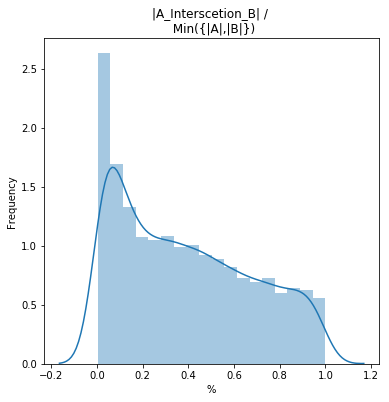

In [14]:
movie_to_users_set = df.groupby('movie')['user'].apply(set)
movie_to_movie_interaction_count = {}
for movie_i in tqdm(movie_to_users_set.index.tolist(),total = N_MOVIES):
    for movie_j in movie_to_users_set.index.tolist():
        in_dict = ((movie_i, movie_j) in movie_to_movie_interaction_count) or ((movie_j, movie_i) in movie_to_movie_interaction_count)
        if (movie_i == movie_j) or in_dict:
            pass
        else:
            min_ = min(len(movie_to_users_set[movie_i]),len(movie_to_users_set[movie_j]))
            max_ = max(len(movie_to_users_set[movie_i]),len(movie_to_users_set[movie_j]))
            movie_to_movie_interaction_count[(movie_i, movie_j)] = (len(movie_to_users_set[movie_i].intersection(movie_to_users_set[movie_j])) , (min_,max_))
# movie_to_movie_interaction_count
fig = plt.figure(figsize=(6,6))
axes = sns.distplot([tup[1][0]/tup[1][1] for tup in movie_to_movie_interaction_count.values()])
axes.set_xlabel('%')
axes.set_ylabel('Frequency')
axes.set_title('|A_Interscetion_B| / \n Min({|A|,|B|})')

In [15]:
THR = 0.35
nodes_connectivity = pd.DataFrame()
counter = 0
for node_i, node_j in movie_to_movie_interaction_count.keys():
    tup = movie_to_movie_interaction_count[(node_i, node_j)]
    ratio = tup[1][0]/tup[1][1] 
    if  ratio > THR:
        nodes_connectivity.loc[counter, 'movie_1'] = node_i
        nodes_connectivity.loc[counter, 'movie_2'] = node_j
        counter += 1
# nodes_connectivity
G_movie = nx.from_pandas_edgelist(nodes_connectivity, 'movie_1', 'movie_2').to_undirected()

In [16]:
def print_attributes(G):
# Diameter, Connected, Degree Assortativity Coefficient
    dict_data = {}
    info = nx.info(G)
    print (info)
    splited = info.splitlines()
    for s in splited:
        split = s.strip().split(":")
        dict_data[split[0]]=split[1]       
    dac = nx.degree_assortativity_coefficient(G)
    print ('Degree Assortativity Coefficient (r): %s' % dac)
    if not nx.is_directed(G):
        if nx.is_connected(G):
            diameter = nx.diameter(G)
            print ('Diameter: %s' % diameter) # print diameter of the network
            dict_data["Diameter"] = diameter
            return dict_data
        else:
            print ('Graph not connected: infinite path length')
            large_comp = len(max(nx.connected_components(G), key=len))
            print ('Size of largest component: %s' % large_comp)
            dict_data["largest component"] = large_comp
            return dict_data
print_attributes(G_movie)

Name: 
Type: Graph
Number of nodes: 100
Number of edges: 2447
Average degree:  48.9400
Degree Assortativity Coefficient (r): 0.5861779075327819
Diameter: 6


{'Name': '',
 'Type': ' Graph',
 'Number of nodes': ' 100',
 'Number of edges': ' 2447',
 'Average degree': '  48.9400',
 'Diameter': 6}

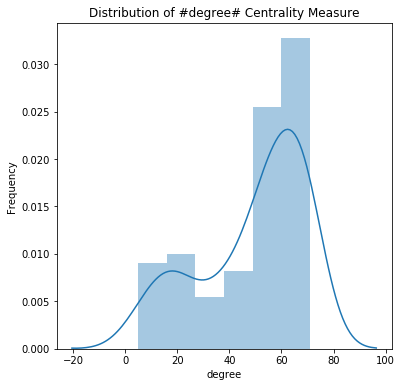

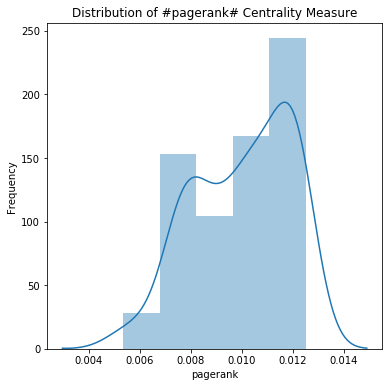

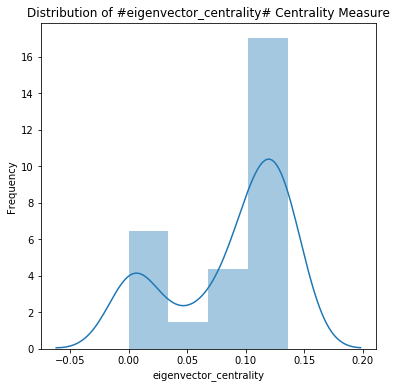

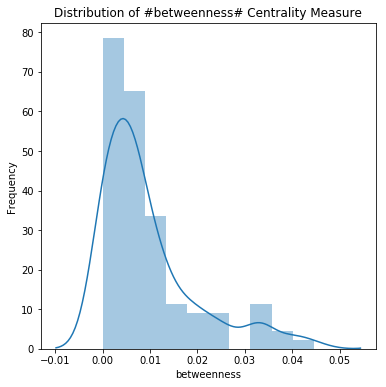

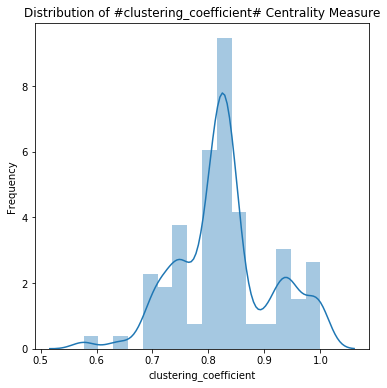

In [17]:
centrality = {'degree' :  nx.degree,
             'pagerank' : nx.pagerank,
             'eigenvector_centrality' : nx.eigenvector_centrality,
             'betweenness' : nx.betweenness_centrality,
             'clustering_coefficient' : nx.clustering}

def calculate_centrality_measure(G, centrality_measure, centrality_name, plot=False): 
    centrality_dict = centrality_measure(G)
    nx.set_node_attributes(G, centrality_dict, centrality_name)
    df_centrality = pd.DataFrame.from_dict(dict(centrality_dict), orient='index', columns=[centrality_name]).sort_values(by= centrality_name, ascending=False)
    df_centrality['movie'] = df_centrality.index
    if plot:
        fig = plt.figure(figsize=(6,6))
        axes = sns.distplot(df_centrality[centrality_name])
        axes.set_xlabel('{}'.format(centrality_name))
        axes.set_ylabel('Frequency')
        axes.set_title('Distribution of #{}# Centrality Measure'.format(centrality_name))
    return G, df_centrality

dfs = []
for measure_key,measure_value in centrality.items():
    G_movie, df_centrality = calculate_centrality_measure(G_movie, measure_value,measure_key, True)
    dfs.append(df_centrality)
df_final = reduce(lambda left,right: pd.merge(left, right, on='movie'), dfs)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001AF7F885B00>,
      dtype=object)

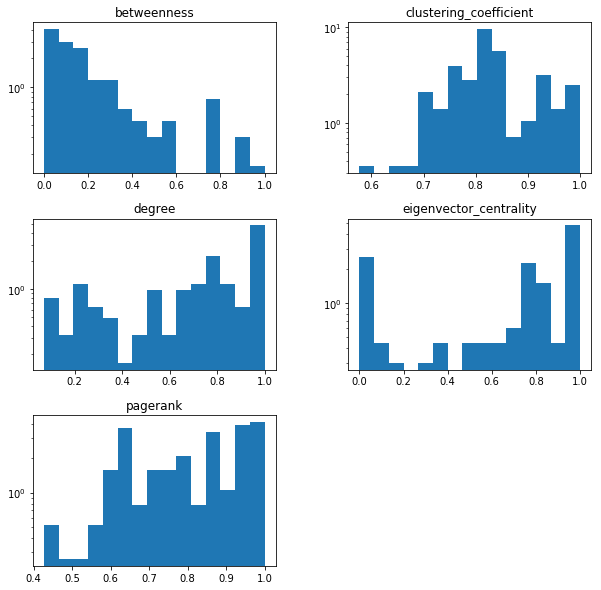

In [19]:
"""
plot histogram of all measures
"""
for col in df_final.columns:
    if col!='movie':
        df_final[col] = df_final[col] / max(df_final[col])
df_final.set_index('movie',inplace=True)
df_final.hist(bins=15,figsize=(10,10), density=True, align='mid',log =True,grid =False)

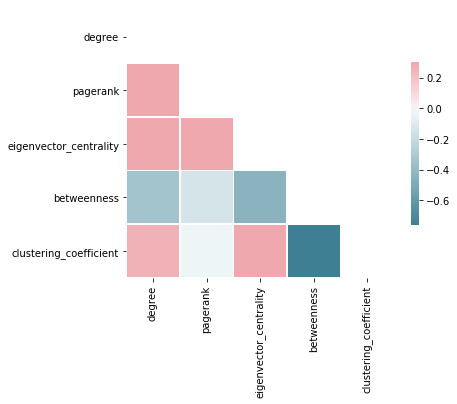

In [20]:
"""
create a Corr plot between the measures
"""
corr = df_final.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(6, 6))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

# Plot the top 10 Movies (ordered by one measure) and their centrality attributes

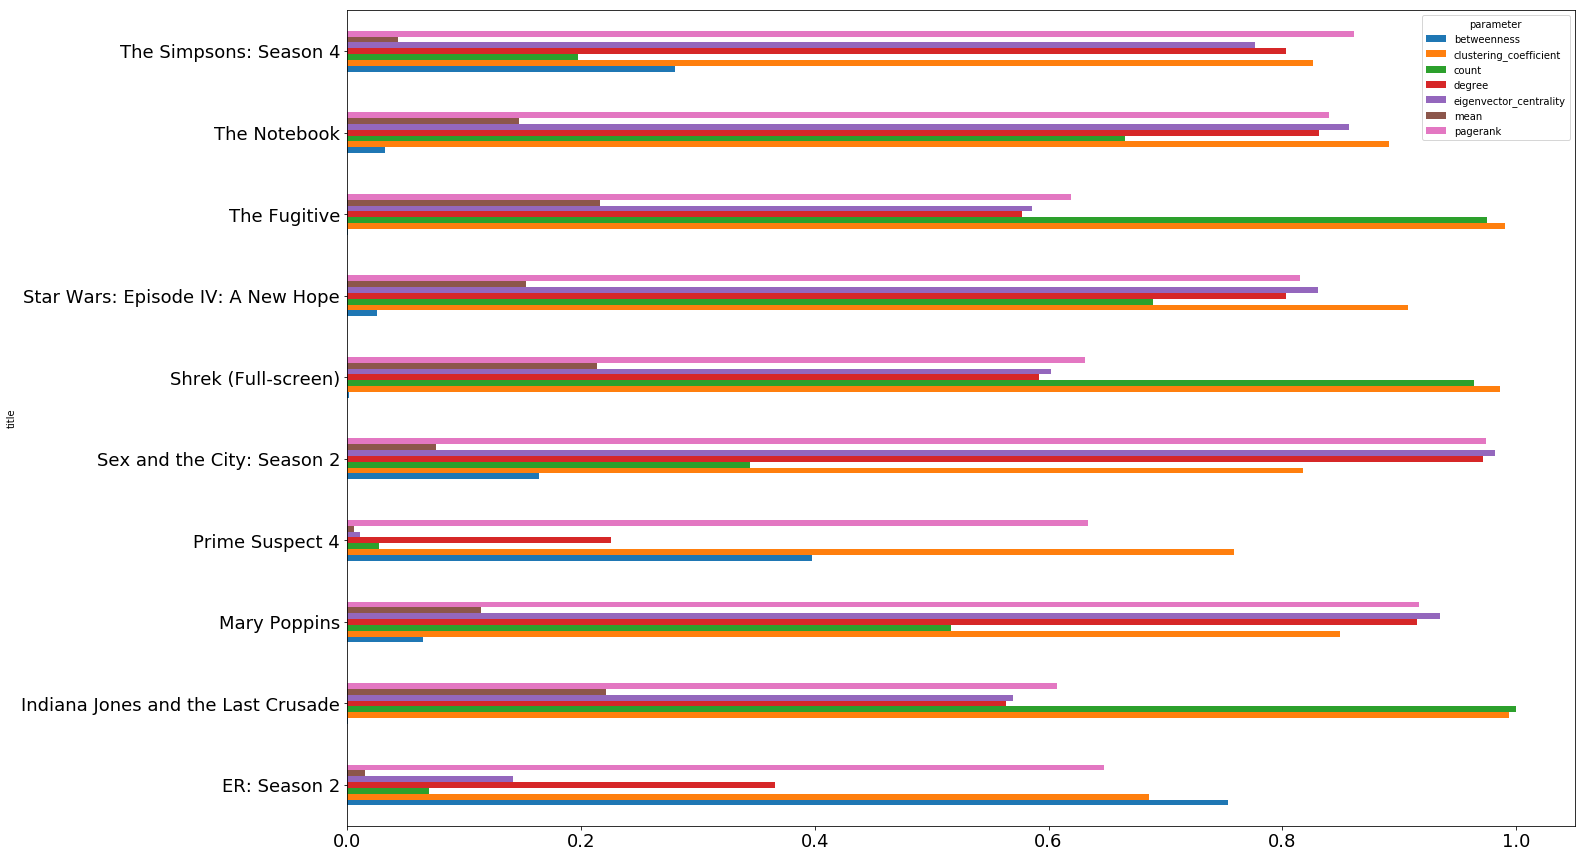

In [22]:
# df = pd.DataFrame(data, columns=['week', 'category', 'count'])
top_df = df_final.merge(grouped_movies, how='left', on='movie').sort_values(['mean','count'], ascending=False)[:10]
top_df.set_index('title', inplace=True)
top_df.drop(['movie'], axis=1, inplace=True)
top_df.drop(['std'], axis=1, inplace=True)
top_df['count']=top_df['count']/top_df['count'].max()
top_df['mean']=top_df['count']/top_df['mean'].max()
top_df = pd.DataFrame(top_df.stack()).reset_index()
top_df.columns = ['title', "parameter", "value"]
top_df['title'] = top_df['title'].astype("category") 
top_df['value'] = top_df['value'].apply(pd.to_numeric)

pt = top_df.pivot('title', 'parameter', 'value')
pt.plot(kind='barh', stacked=False, figsize=(22, 15),fontsize=18)


In [23]:
pt

parameter,betweenness,clustering_coefficient,count,degree,eigenvector_centrality,mean,pagerank
title,,,,,,,
ER: Season 2,0.753585,0.686154,0.069869,0.366197,0.141947,0.015487,0.647754
Indiana Jones and the Last Crusade,0.000679,0.993590,1.000000,0.563380,0.569748,0.221662,0.607071
Mary Poppins,0.064669,0.849038,0.516717,0.915493,0.934518,0.114536,0.916809
Prime Suspect 4,0.397922,0.758333,0.026883,0.225352,0.011356,0.005959,0.633871
Sex and the City: Season 2,0.163914,0.817562,0.344432,0.971831,0.981573,0.076347,0.974105
Shrek (Full-screen),0.001617,0.986063,0.963701,0.591549,0.601797,0.213616,0.631210
Star Wars: Episode IV: A New Hope,0.025333,0.907268,0.689547,0.802817,0.830522,0.152846,0.814950
The Fugitive,0.001082,0.990244,0.975368,0.577465,0.585852,0.216202,0.619134
The Notebook,0.032603,0.891292,0.665052,0.830986,0.857239,0.147417,0.840139


### Plot knn as function of k

Fit function of the form:  $a\cdot X^{\mu}$

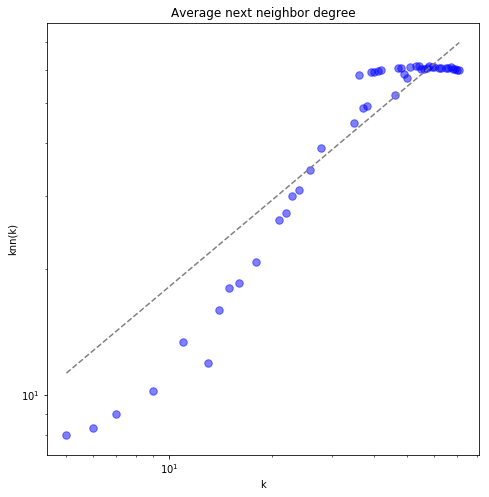

In [24]:
def fit_func(x,a,mu):
    return (a*x)**mu

def plot_knn(G, fit=True): 
    knn_dict = nx.k_nearest_neighbors(G) # k_nearest_neighbors return dict with knn for each k
    k_lst = sorted(knn_dict.keys())
    knn_lst = []
    for k in k_lst:
        knn_lst.append(knn_dict[k])
    # plotting
    fig = plt.figure(figsize=(6,6))
    axes = fig.add_axes([1,1,1,1])
    axes.loglog(k_lst,knn_lst,'b.', markersize=15, alpha=0.5)
    axes.set_xlabel('k')
    axes.set_ylabel('knn(k)')
    axes.set_title('Average next neighbor degree')
    try:
        if fit:
            # fit a*x^mu
            popt, pcov = curve_fit(fit_func, np.array(k_lst), np.array(knn_lst))
            axes.loglog(np.array(k_lst), fit_func(np.array(k_lst), *popt), '--', c='gray')

        plt.show()
    except:
        print ("RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 600.")
plot_knn(G_movie, fit=True)    

### Plot snn as function of k

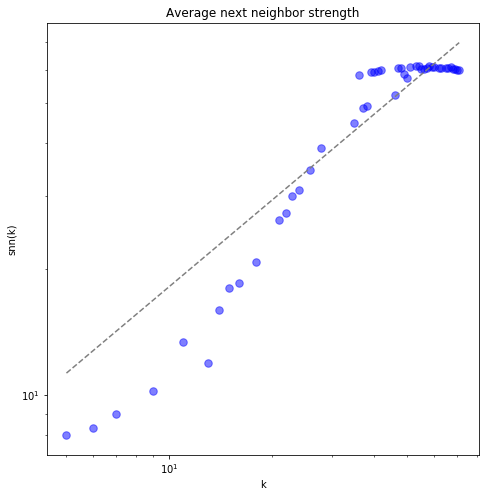

In [25]:
def plot_snn(G, fit=True): 
    snn_dict = nx.k_nearest_neighbors(G, weight='weight') 
    k_lst = sorted(snn_dict.keys())
    snn_lst = []
    for k in k_lst:
        snn_lst.append(snn_dict[k])
    # plotting
    fig = plt.figure(figsize=(6,6))
    axes = fig.add_axes([1,1,1,1])
    axes.loglog(k_lst,snn_lst,'b.', markersize=15, alpha=0.5)
    axes.set_xlabel('k')
    axes.set_ylabel('snn(k)')
    axes.set_title('Average next neighbor strength')
    try:
        if fit:
            # fit a*x^mu
            popt, pcov = curve_fit(fit_func, np.array(k_lst), np.array(snn_lst))
            axes.loglog(np.array(k_lst), fit_func(np.array(k_lst), *popt), '--', c='gray')
        plt.show()
    except:
        print ("RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 600.")
plot_snn(G_movie, fit=True)

### Clustering coefficient for k
calculate C(k) the average clustering coefficient for nodes with degree k.

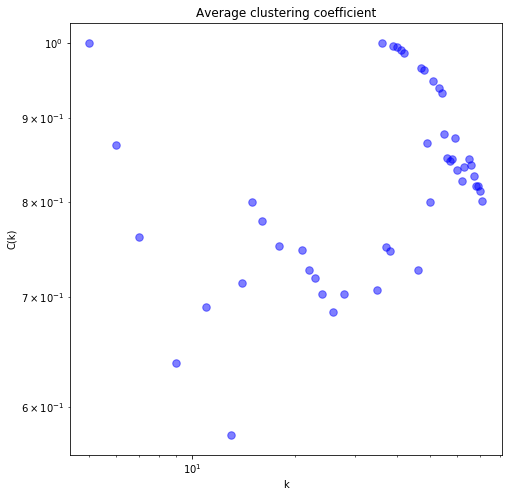

In [26]:
def plot_clustering_coefficient(G):
    clustering_dict = {}
    for node in G.nodes():
        k = G.degree(node)
        if not k in clustering_dict:
            clustering_dict[k] = [nx.clustering(G,node)]
        else:
            clustering_dict[k].append(nx.clustering(G,node))
    k_lst = sorted(clustering_dict.keys())
    clustering_lst = []
    for k in k_lst:
        clustering_lst.append(np.array(clustering_dict[k]).mean())
    # plotting
    fig = plt.figure(figsize=(6,6))
    axes = fig.add_axes([1,1,1,1])
    axes.loglog(k_lst,clustering_lst,'b.', markersize=15, alpha=0.5)
    axes.set_xlabel('k')
    axes.set_ylabel('C(k)')
    axes.set_title('Average clustering coefficient')
    plt.show()
plot_clustering_coefficient(G_movie)

# Graph differences over time

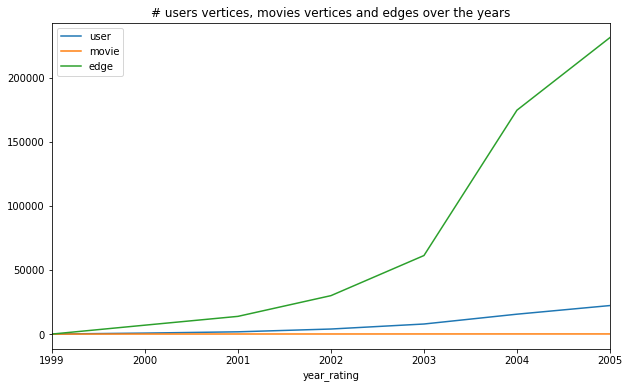

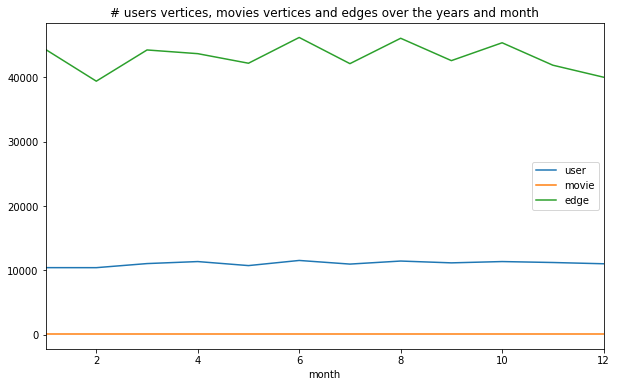

In [28]:
def dif_year(df):
    df.groupby(['year_rating'])['user','movie','edge'].nunique().reset_index().plot(x='year_rating',y=['user','movie','edge'], figsize=(10,6),title='# users vertices, movies vertices and edges over the years')
    df.groupby(['month'])['user','movie','edge'].nunique().reset_index().plot(x='month',y=['user','movie','edge'], figsize=(10,6), title='# users vertices, movies vertices and edges over the years and month')
    plt.show()
dif_year(df)

# Create graph for each year

In [29]:
years = [2001,2002, 2003, 2004, 2005] #selected years
Gs = [] # Initialize an empty list: Gs
for year in years:
    # Instantiate a new undirected graph: G
    G = nx.Graph()
    # Add in all nodes that have ever shown up to the graph
    G.add_nodes_from(df['user'])
    G.add_nodes_from(df['movie'])
    # Filter the DataFrame so that there's only the given month
    df_filtered = df[df['year_rating'] == year]
    # Add edges from filtered DataFrame
    G.add_weighted_edges_from(df_filtered['edge'])
    # Append G to the list of graphs
    Gs.append(G)

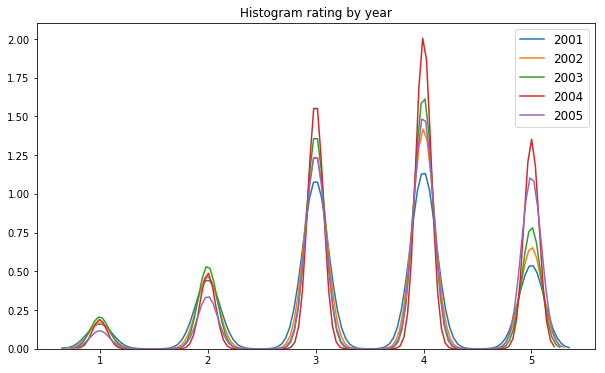

In [30]:
# change in mean rating for movies over time 
data = {}
plt.figure(figsize=(10, 6))
for i,g in enumerate(Gs):
    weight=nx.get_edge_attributes(g,'weight')
    #plt.hist(weight.values(), bins='auto',label =year[i])  # arguments are passed to np.histogram
    sns.distplot(list(weight.values()), hist=False, label=str(years[i]))

plt.legend(prop={'size': 12})
plt.title("Histogram rating by year")
plt.show()

In [31]:
def g_difference(Gs, years):
    # Instantiate a list of graphs that show edges added: added
    added = []
    # Instantiate a list of graphs that show edges removed: removed
    removed = []
    # Here's the fractional change over time
    fractional_changes = []
    window = 1  
    i = 0      
    years_diff = []
    for i in range(len(Gs) - window):
        g1 = Gs[i]
        g2 = Gs[i + window]
        years_diff.append(str(years[i])+"-"+str(years[i + window]))
        # Compute graph difference here
        added.append(nx.difference(g2, g1))   
        removed.append(nx.difference(g1, g2))

        # Compute change in graph size over time
        fractional_changes.append((len(g2.edges()) - len(g1.edges())) / len(g1.edges()))

    # Print the fractional change
    print("fractional change:{}, {}".format(fractional_changes[0],fractional_changes[1]))
    
    return added, removed, fractional_changes, years_diff
    
# plot number of edge changes over time
def plot_diffrences(added, removed, fractional_changes,years):
    fig = plt.figure(figsize=(10, 6))
    
    ax1 = fig.add_subplot(111)

    # Plot the number of edges added over time & the number of edges removed over time
    edges_added = [len(g.edges()) for g in added]
    edges_removed = [len(g.edges()) for g in removed]
    df = pd.DataFrame()
    df['year'] = years
    df['edges_added'] = edges_added
    df['edges_removed'] = edges_removed
    df['fractional_changes'] = fractional_changes
    df_plot = pd.melt(df, id_vars=['year'], value_vars=['edges_added', 'edges_removed','fractional_changes'])
    
    
    grid = sns.barplot(x='year', y='value', hue='variable', data=df_plot)
    #grid.set(yscale="log")
    plt.xlabel('year') 
    plt.ylabel('Changes in edges over time')         
    plt.show()

# plot number of edges over time
def plot_num_edges_over_time(Gs, years):    
    plt.figure(figsize=(10, 6))
    df = pd.DataFrame()
    df['year'] = years
    res = []
    for i,G in enumerate(Gs):
        # Plot edge sizes over time
        res.append(len(G.edges()))
    df['num_edges'] = res
    df['num_edges_norm'] = df['num_edges']/df['num_edges'].max()
    sns.barplot(x="year", y="num_edges", data=df)
    plt.xlabel('year') 
    plt.ylabel('Norm Number of edges')                           
    plt.show()
    
# degree centrality over time
def dc_time(G_list,years):
    
    plt.figure(figsize=(10, 6))
    df = pd.DataFrame()
    for i,G in enumerate(G_list):
        cen_val = np.array(list(dict(nx.degree(G)).values()))
        df[years[i]] =  cen_val/cen_val.max()
        df[years[i]].hist(alpha = 0.3, label=years[i])
    plt.yscale('log')
    plt.xscale('log')
    plt.xlabel('Degree Centrality') 
    plt.ylabel('P(Degree Cenrality)')  
    plt.legend()   
    plt.show()

fractional change:1.1703805527420055, 1.0434681156038534


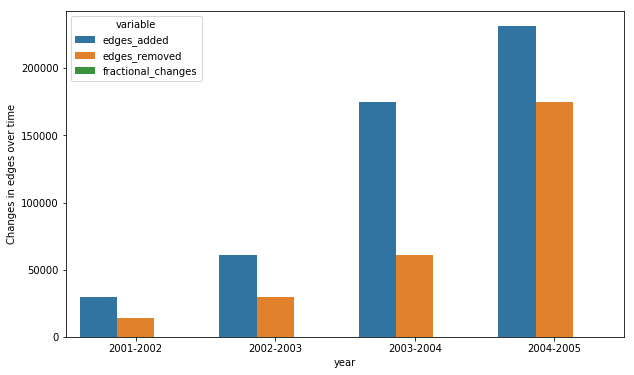

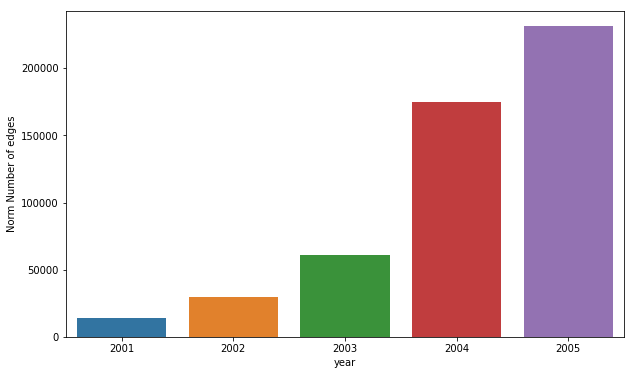

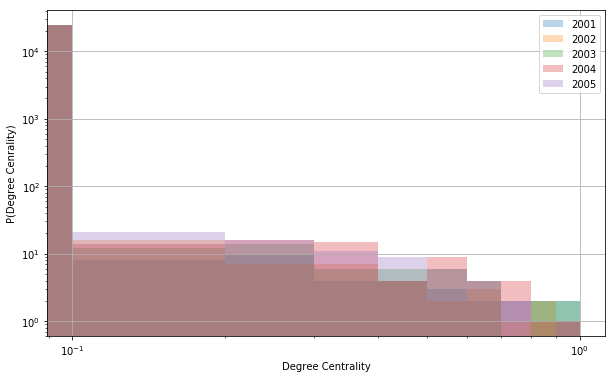

In [32]:
added,removed,fractional_changes,years_diff = g_difference(Gs, years)
plot_diffrences(added, removed, fractional_changes, years_diff)
plot_num_edges_over_time(Gs, years)
dc_time(Gs, years)

## Cluester similar movies

In [ ]:
def community_best_partition(G):
    communities = community.best_partition(G)
    nx.set_node_attributes(G, communities, 'modularity')
    return G

def community_kernighan_lin_bisection(G):
    KL_communities_generator = community.kernighan_lin_bisection(G,max_iter=10)
    for s in KL_communities_generator:
        print (s)
        
def community_girvan_newman(G):  
    GN_communities_generator = community.girvan_newman(G)
    top_level_communities = next(GN_communities_generator)
    next_level_communities = next(GN_communities_generator)
    GN_comm_sets = sorted(map(sorted, next_level_communities))

def modularity(G,communites):
    return community.modularity(G,communites)

## Plot the graph

In [ ]:
def plot_g(G):
    nx.draw(G, pos=nx.spring_layout(G_movies), with_labels = True, node_color = "#00CCFF")
    plt.show()

def CircosPlot(G, grouping):
    c = CircosPlot(
        G,
        dpi=600,
        node_grouping=grouping,
        edge_width="count",
        figsize=(20, 20),
        node_color=grouping,
        node_labels=True,
    )
    c.draw()
    plt.show()

def ArcPlot(G, grouping):
    a = ArcPlot(G, node_color=grouping, node_grouping=grouping)
    a.draw()

In [ ]:
G = community_best_partition(G)
#plotting the communities
plot_g(G)
CircosPlot(G, 'communities')
ArcPlot(G, 'communities')

## Friend Recommendation: Open Triangles
we want to see if we can do some friend recommendations by looking for open triangles.
Open triangles are - A knows B and B knows C, but C's relationship with A isn't captured in the graph.
What are the two general scenarios for finding open triangles that a given node is involved in?
The given node is the centre node.
The given node is one of the termini nodes.

In [ ]:
def get_open_triangles(G, node):
    open_triangle_nodes = []
    neighbors = set(G.neighbors(node))
    
    for n1, n2 in combinations(neighbors, 2):
        if not G.has_edge(n1, n2):
            open_triangle_nodes.append([n1, node, n2])
            frieds_pair_recomded.append((n1, n2))
    preds = nx.jaccard_coefficient(G, frieds_pair_recomded)
#     for u, v, p in preds:
#         '(%d, %d) -> %.8f' % (u, v, p)
    df = pd.DataFrame(list(preds),columns=['n1','n2','jaccard']).sort_values(by=['n1','n2','jaccard'])
    max_jaccard_by_user = df.groupby('n')['jaccard'].max().reset_index(name='max')
    return open_triangle_nodes, max_jaccard_by_user

# find shared movies: Transposition

In [ ]:
def user_user_projection_matrix(G):
    #compute adjacency matrix
    # Get the list of people and list of clubs from the graph: users_nodes, movies_nodes
    users_nodes = get_nodes_from_partition(G, 'users')
    movies_nodes = get_nodes_from_partition(G, 'movies')

    # Compute the biadjacency matrix: bi_matrix
    bi_matrix = nx.bipartite.biadjacency_matrix(G, row_order=users_nodes, column_order=movies_nodes)

    # Compute the user-user projection: user_matrix
    user_matrix = bi_matrix @ bi_matrix.T

    return users_nodes, user_matrix

def sharing(user_matrix, user_nodes):
    # Find out the users who rated the most number of movies
    diag = user_matrix.diagonal() 
    indices = np.where(diag == diag.max())[0]  
    print('Number of movies: {0}'.format(diag.max()))
    print('Users with the most # rating:')
    for i in indices:
        print('- {0}'.format(user_nodes[i]))

    # Set the diagonal to zero and convert it to a coordinate matrix format
    user_matrix.setdiag(0)
    users_coo = user_matrix.tocoo()

    # Find pairs of users who shared rating in the most number of movies
    indices = np.where(users_coo.data == users_coo.data.max())[0]
    print('Users with most shared movies:')
    for idx in indices:
        print('- {0}, {1}'.format(user_nodes[users_coo.row[idx]], user_nodes[users_coo.col[idx]]))

In [ ]:
get_open_triangles(G, node)
users_nodes, user_matrix = user_user_projection_matrix(G)  
sharing(user_matrix, user_nodes)